<a href="https://colab.research.google.com/github/Ousmane-Camara1/Copy_Move_Forgery_Detection/blob/main/mini1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

fatal: destination path '/content/e4e' already exists and is not an empty directory.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/e4e/requirements.txt'
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.
Device: cuda
File ‘/content/drive/MyDrive/mini/ffhq.pkl’ already there; not retrieving.
replace /content/images1024x1024/00001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N

--- Pair 1 ---

--- Pair 2 ---

--- Pair 3 ---


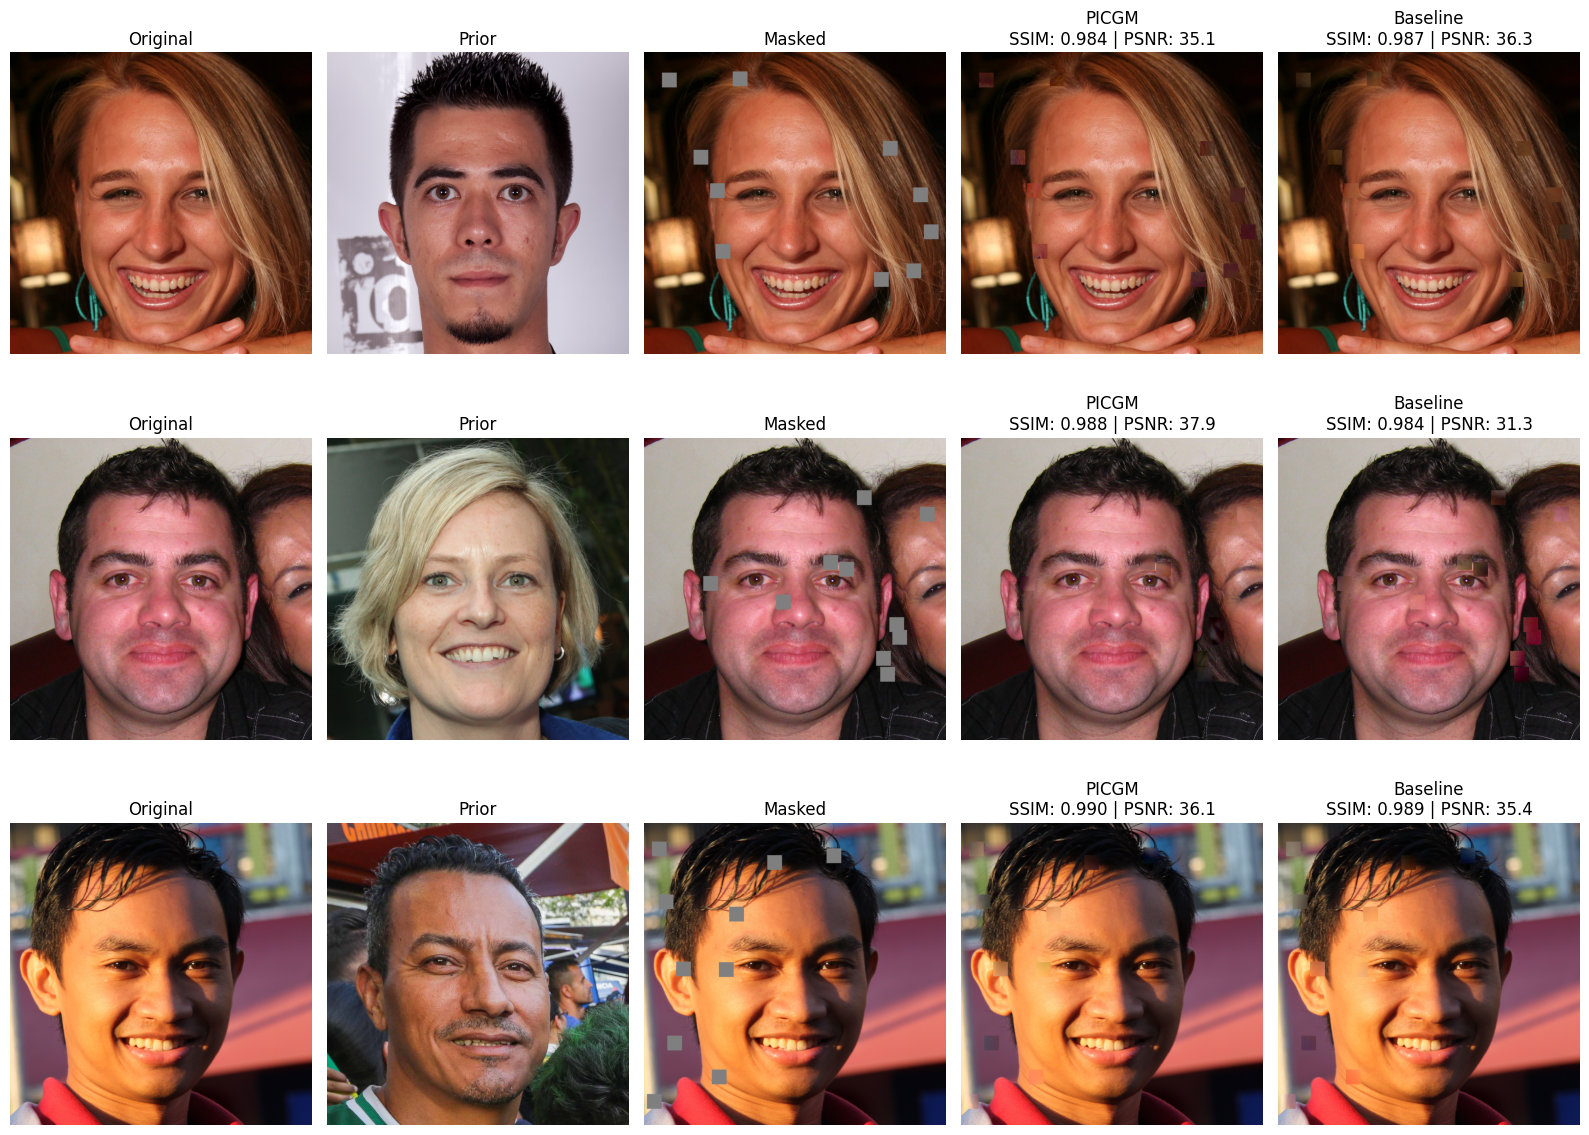

In [11]:
# === INSTALL E4E ===
!git clone https://github.com/omertov/encoder4editing.git /content/e4e
!pip install -r /content/e4e/requirements.txt
!pip install -q tensorboardX

# === MOUNT DRIVE ===
from google.colab import drive
drive.mount('/content/drive')

# === INSTALL DEPENDENCIES ===
!pip install -q imageio imageio-ffmpeg ninja lpips
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install -q face-alignment

# === IMPORTS ===
import sys
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import glob
import lpips
import face_alignment
import torchvision.transforms.functional as TF
import skimage.metrics

sys.path.append('/content/stylegan2-ada-pytorch')

# === SETUP ===
drive_path = '/content/drive/MyDrive/mini'
os.makedirs(drive_path, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# === DOWNLOAD FFHQ.PKL MODEL ===
!wget -nc -O {drive_path}/ffhq.pkl https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

# === LOAD MODEL ===
import dnnlib
import legacy

def load_model(path):
    with dnnlib.util.open_url(path, verbose=False) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device).eval()
    return G

G = load_model(f"{drive_path}/ffhq.pkl")

# === FACE ALIGNMENT SETUP ===
fa = face_alignment.FaceAlignment('2D', flip_input=False, device=device)

def postprocess(t):
    return ((t.clamp(-1, 1) + 1) / 2).permute(1, 2, 0).detach().cpu().numpy()

def is_frontal(img_tensor, threshold=0.3):
    img_np = postprocess(img_tensor).copy()
    landmarks = fa.get_landmarks_from_image((img_np * 255).astype(np.uint8))
    if landmarks is None or len(landmarks) == 0:
        return False
    left_eye = landmarks[0][36]
    right_eye = landmarks[0][45]
    dx = abs(left_eye[1] - right_eye[1])
    dy = abs(left_eye[0] - right_eye[0])
    angle = np.arctan2(dx, dy)
    return angle < threshold

# === UNZIP FFHQ IMAGES ===
ffhq_zip_path = f"{drive_path}/images1024x1024.zip"
ffhq_extract_path = "/content/images1024x1024"


!mkdir -p {ffhq_extract_path}
!unzip -q {ffhq_zip_path} -d {ffhq_extract_path}

# === LOAD FFHQ AS CUSTOM DATASET ===
class FFHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(root_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


ffhq_dataset = FFHQDataset(ffhq_extract_path, transform=transform)

# === GET 3 IMAGE PAIRS ===
pairs = []
for i in range(0, len(ffhq_dataset) - 1, 2):
    target = ffhq_dataset[i]
    prior = ffhq_dataset[i+1]
    if is_frontal(target) and is_frontal(prior):
        pairs.append((target, prior))
    if len(pairs) == 3:
        break

# === IMAGE MASKING HELPER ===
def apply_mask(img, size=224):
    masked = img.clone()
    c_h, c_w = img.shape[1] // 2, img.shape[2] // 2
    h = size // 2
    mask = torch.ones_like(img)
    masked[:, c_h-h:c_h+h, c_w-h:c_w+h] = 0
    mask[:, c_h-h:c_h+h, c_w-h:c_w+h] = 0
    return masked, mask
import random

def apply_multiple_masks(img, num_masks=10, size=50):
    masked = img.clone()
    mask = torch.ones_like(img)

    H, W = img.shape[1], img.shape[2]
    for _ in range(num_masks):
        center_h = random.randint(size // 2, H - size // 2)
        center_w = random.randint(size // 2, W - size // 2)
        h = size // 2

        masked[:, center_h - h:center_h + h, center_w - h:center_w + h] = 0
        mask[:, center_h - h:center_h + h, center_w - h:center_w + h] = 0

    return masked, mask


# === INVERSION FUNCTION ===
def invert_image(img, G, steps=500, lr=0.07, mask=None):
    img = img.unsqueeze(0).to(device)
    z = torch.randn((1, G.z_dim), device=device)
    w = G.mapping(z, None)

    if w.ndim == 2:
        w_plus = w.unsqueeze(1).repeat(1, G.synthesis.num_ws, 1)
    elif w.ndim == 3:
        w_plus = w
    else:
        raise ValueError(f"Unexpected w shape: {w.shape}")

    w_plus = w_plus.detach().clone().requires_grad_(True)
    optimizer = torch.optim.Adam([w_plus], lr=lr)

    for step in range(steps):
        gen = G.synthesis(w_plus, noise_mode='const')[0].unsqueeze(0)
        gen_resized = torch.nn.functional.interpolate(gen, size=(1024, 1024), mode='bilinear', align_corners=False)
        if mask is not None:
            mask = mask.to(device)
            loss = torch.nn.functional.mse_loss(gen_resized * (1 - mask), img * (1 - mask))
        else:
            loss = torch.nn.functional.mse_loss(gen_resized, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return w_plus.detach()




# === BASELINE RECONSTRUCTION ===
def baseline_reconstruct(w_init, img_target, mask, G, img_original, steps=500, lr=0.07):
    img_target = img_target.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    img_original = img_original.unsqueeze(0).to(device)

    w_opt = w_init.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([w_opt], lr=lr)

    for step in range(steps):
        gen = G.synthesis(w_opt, noise_mode='const')[0].unsqueeze(0)
        gen_resized = torch.nn.functional.interpolate(gen, size=(1024, 1024), mode='bilinear', align_corners=False)
        loss = torch.nn.functional.mse_loss(gen_resized * mask, img_target * mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    final_output = img_original * mask + gen_resized * (1 - mask)
    return final_output



# === PICGM RECONSTRUCTION ===
def picgm_reconstruct(w_prior, w_init, img_target, mask, G, img_original, steps=500, lr=0.07, p1=4):
    img_target = img_target.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    img_original = img_original.unsqueeze(0).to(device)

    w_opt = w_init.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([w_opt], lr=lr)

    for step in range(steps):
        w_mix = torch.cat([w_prior[:, :p1], w_opt[:, p1:]], dim=1)
        gen = G.synthesis(w_mix, noise_mode='const')[0].unsqueeze(0)
        gen_resized = torch.nn.functional.interpolate(gen, size=(1024, 1024), mode='bilinear', align_corners=False)
        loss = torch.nn.functional.mse_loss(gen_resized * mask, img_target * mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    final_output = img_original * mask + gen_resized * (1 - mask)
    return final_output



# === RUN RECONSTRUCTION ON 3 PAIRS ===
results = []
for i, (target, prior) in enumerate(pairs):
    print(f"\n--- Pair {i+1} ---")
    masked, mask = apply_multiple_masks(target)

    # === Latent codes for prior and corrupted image ===
    w_prior = invert_image(prior, G)
    w_init = invert_image(masked, G, mask=mask)

    # === Reconstructions ===
    baseline = baseline_reconstruct(w_init, masked, mask, G, target)
    picgm = picgm_reconstruct(w_prior, w_init, masked, mask, G, target)

    results.append((target, prior, masked, baseline, picgm))

# === METRICS & VISUALIZATION ===
def compute_metrics(pred, target):
    pred_np = postprocess(pred[0])
    target_np = postprocess(target.squeeze(0))
    ssim = skimage.metrics.structural_similarity(pred_np, target_np, channel_axis=2, data_range=1.0)
    psnr = skimage.metrics.peak_signal_noise_ratio(pred_np, target_np, data_range=1.0)
    return ssim, psnr

def show_rows(pairs, reconstructions):
    n = len(pairs)
    plt.figure(figsize=(16, 4 * n))
    for i, (target, prior, masked, baseline, picgm) in enumerate(reconstructions):
        ssim_b, psnr_b = compute_metrics(baseline, target)
        ssim_p, psnr_p = compute_metrics(picgm, target)
        images = [target, prior, masked, picgm, baseline]
        col_titles = ["Original", "Prior", "Masked",
                      f"PICGM\nSSIM: {ssim_p:.3f} | PSNR: {psnr_p:.1f}",
                      f"Baseline\nSSIM: {ssim_b:.3f} | PSNR: {psnr_b:.1f}"]
        for j, (img, title) in enumerate(zip(images, col_titles)):
            idx = i * 5 + j + 1
            plt.subplot(n, 5, idx)
            plt.imshow(postprocess(img[0] if img.ndim == 4 else img))
            plt.title(title)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

show_rows(pairs, results)
